In [313]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import batman

import astropy.units as u
from astropy.timeseries import BoxLeastSquares
from scipy.optimize import curve_fit
from scipy.optimize import least_squares

import emcee
import corner

In [314]:
import photoeccentric as ph

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [315]:
smass_kg = 1.9885e30  # Solar mass (kg)
srad_m = 696.34e6 # Solar radius (m)

In [18]:
#Kepler planets with spectroscopy
rho_lum = pd.read_csv('/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/Data/rhos/rho_lum.csv')

# ALL Kepler planets from exo archive
planets = pd.read_csv('/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/Data/exoplanetarchive/cumulative_kois.csv')

# Take the Kepler planet archive entries for the planets we have spectroscopy for
spectplanets = planets[planets['kepid'].isin(list(rho_lum.columns))]
spectplanets = spectplanets.reset_index()

In [19]:
#spectplanets

In [24]:
spectplanets.loc[spectplanets['kepid'] == 4061149]
#spectplanets.loc[spectplanets['kepler_name'] == "Kepler-446 b"]

,index,kepid,kepoi_name,kepler_name,koi_disposition,koi_vet_stat,koi_vet_date,koi_pdisposition,koi_score,koi_fpflag_nt,...,koi_dicco_mdec,koi_dicco_mdec_err,koi_dicco_msky,koi_dicco_msky_err,koi_dikco_mra,koi_dikco_mra_err,koi_dikco_mdec,koi_dikco_mdec_err,koi_dikco_msky,koi_dikco_msky_err
11,431,4061149,K01201.01,NaN,CANDIDATE,Done,8/16/18,CANDIDATE,1.0,0,...,-0.12,0.32,0.71,0.3,0.24,0.31,-0.32,0.32,0.4,0.32


In [21]:
kepname = "Kepler-446 b"

### Planet & Star Parameters from Archive

In [22]:
smass, smass_uerr, smass_lerr, srad, srad_uerr, srad_lerr, ldmod, ldm_c1, ldm_c2 = ph.stellar_params_from_archive(spectplanets, kepname)
period, period_uerr, period_lerr, rprs, rprs_uerr, rprs_lerr, a, a_uerr, a_lerr, i, e, w = ph.planet_params_from_archive(spectplanets, kepname)

smass_err = np.mean((smass_uerr, np.abs(smass_lerr)))
srad_err = np.mean((srad_uerr, np.abs(srad_lerr)))
period_err = np.mean((period_uerr, np.abs(period_lerr)))
rprs_err = np.mean((rprs_uerr, np.abs(rprs_lerr)))
a_err = np.mean((a_uerr, np.abs(a_lerr)))

print('Stellar mass: ', smass, 'Stellar radius: ', srad)
print('Period: ', period, 'Rp/Rs: ', rprs)
print('a: ', a)
print('i: ', i)

Stellar mass:  0.32799999999999996 Stellar radius:  0.32799999999999996
Period:  1.5654126130000001 Rp/Rs:  0.048437
a:  16.57
i:  89.99


### Planet & Star Parameters Made Up (Consistent with Archive)

In [23]:
# Stellar mass from Gaia/Spec
smass_2 = 0.15543012670105222
smass_err_2 = 0.011230570640734436

# Stellar radius from Gaia/Spec
srad_2 = 0.17888163900857723
srad_err_2 = 0.011918741224718215

period_2 = period
period_err_2 = period_err

rprs_2 = rprs
rprs_err_2 = rprs_err

a_2 = ph.calc_a(period_2*86400.0, smass_2*smass_kg, srad_2*srad_m)
a_err_2 = a_err

i_2 = i

print('Stellar mass: ', smass_2, 'Stellar radius: ', srad_2)
print('Period: ', period_2, 'Rp/Rs: ', rprs_2)
print('a: ', a_2)
print('i: ', i_2)

Stellar mass:  0.15543012670105222 Stellar radius:  0.17888163900857723
Period:  1.5654126130000001 Rp/Rs:  0.048437
a:  17.0376699117099
i:  89.99


In [322]:
""" Create mass and radius arrays """

masses_dist = [np.random.normal(smass, np.mean((smass_uerr, np.abs(smass_lerr))), size=100)]
radii_dist = [np.random.normal(srad, np.mean((srad_uerr, np.abs(srad_lerr))), size=100)]
period_dist = [np.random.normal(period, np.mean((period_uerr, np.abs(period_lerr))), size=100)]
rprs_dist = [np.random.normal(rprs, np.mean((rprs_uerr, np.abs(rprs_lerr))), size=100)]
a_dist = [np.random.normal(a, np.mean((a_uerr, np.abs(a_lerr))), size=100)]

##### Density from Archive:

In [323]:
rho, ms, rs = ph.find_density_dist_symmetric(1, [smass], [smass_err], [srad], [srad_err])
rho[0].flatten();
rhos = rho[0]
rho_minuserr, rho_pluserr = ph.get_sigmas(rhos)

print('Mean density: ', np.mean(rhos))

100%|██████████| 1/1 [00:00<00:00, 188.78it/s]

Mean density:  14041.374545485001


###### Density of this star based on Gaia/spec:

In [324]:
rhos_gaia = np.genfromtxt(r'/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/notebooks/jan29_21_rhos_8733898.csv', delimiter=',')

print('Mean density: ', np.mean(rhos_gaia))


Mean density:  38914.793390409744


##### Create a transit model with planet params above.

In [325]:
time = np.linspace(-24, 24, 10000)

In [326]:
def planetlc(time, per, rp, a, inc):
    params = batman.TransitParams()       #object to store transit parameters
    params.t0 = 0.                        #time of inferior conjunction
    params.per = per                      #orbital period
    params.rp = rp                        #planet radius (in units of stellar radii)
    params.a = a                          #semi-major axis (in units of stellar radii)
    params.inc = inc                      #orbital inclination (in degrees)
    params.ecc = 0.2
    params.w = 0.0                        #longitude of periastron (in degrees)
    #params.limb_dark = "linear"
    #params.u = [0.3]
    #params.limb_dark = "quadratic"
    #params.u = [0.1, 0.3]
    params.limb_dark = "uniform"
    params.u = []

    #times to calculate light curve
    m = batman.TransitModel(params, time)
    
    flux = m.light_curve(params)
    
    return flux

In [327]:
# Old a from archive: inconsistent with density
#flux = planetlc(time, period, rprs, a, i)

# Old a from calculation: consistent with density
flux = planetlc(time, period_2, rprs_2, a_2, i_2)

# Adding gaussian noise
noise = np.random.normal(0,0.000005,len(time))
nflux = flux+noise

## Fit transit

#### Astropy BLS

In [328]:
mod = BoxLeastSquares(time*u.day, nflux, dy=0.01)
periodogram = mod.autopower(0.2, objective="snr")

In [329]:
periodogram.period = np.asarray(periodogram.period)
per_guess = periodogram.period[int(np.median(np.argmax(periodogram.power)))]

#### Least-squares using BLS period guess

In [330]:
# Normally I would use the BLS depth, ingress+egress, etc. to guess the other planet params 
# but I'm not going to do that right now because I'm just testing my get_g function

popt, pcov = curve_fit(ph.planetlc_fitter, xdata=time, ydata=nflux, p0=p0, bounds=((-np.inf, -np.inf, 0.0, 0), (np.inf, np.inf, 25.0, 90.0)))



In [331]:
p0 = [per_guess, rprs_2, a, i]
params2 = [popt[0], popt[1], 12.0, 86.0]

fit = planetlc(time, popt[0], popt[1], popt[2], popt[3])
fit2 = planetlc(time, params2[0], params2[1], params2[2], params2[3])

In [332]:
popt

array([ 1.56500475,  0.048437  , 16.57      ,  1.        ])

In [333]:
pcov

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [334]:
params2

[1.5650047547887516, 0.048437, 12.0, 86.0]

In [335]:
ttime = time[2470:2530]
tflux = nflux[2470:2530]
tfit = fit[2470:2530]
tfit2 = fit2[2470:2530]

In [336]:
#popt, pcov = curve_fit(ph.planetlc_fitter, xdata=ttime, ydata=tflux, p0=p0, bounds=((-np.inf, -np.inf, 0.0, 0), (np.inf, np.inf, 100.0, 90.0)))
popt, pcov = curve_fit(ph.planetlc_fitter, xdata=ttime, ydata=tflux, p0=p0)

/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [337]:
popt

array([1.56500475e+00, 4.84370000e-02, 1.65700000e+01, 8.99900000e+01])

In [338]:
p0 = [per_guess, rprs_2, 12.0, 86.0]
params2 = [popt[0], popt[1], 12.0, 86.0]

fit = planetlc(time, popt[0], popt[1], popt[2], popt[3])
fit2 = planetlc(time, params2[0], params2[1], params2[2], params2[3])

In [339]:
p_f = popt[0]*86400 #4.99 days
perr_f = 0.001*86400

rprs_f = popt[1] #0.0704 stellar radii
rprserr_f = 0.001

a_f = popt[2] #stellar radii

i_f = popt[3] #degrees 

In [340]:
p_f2 = params2[0]*86400 #4.99 days
perr_f2 = 0.001*86400

rprs_f2 = params2[1] #0.0704 stellar radii
rprserr_f2 = 0.001

a_f2 = params2[2] #stellar radii

i_f2 = params2[3] #degrees 

In [341]:
print('Period fit: ', p_f/86400.)
print('Rp/Rs fit: ', rprs_f)
print('i fit: ', i_f)
print('a/Rs fit: ', a_f)

Period fit:  1.5650047547887516
Rp/Rs fit:  0.048437
i fit:  89.99
a/Rs fit:  16.57


Note 2/2/2021: The transit fitting is not accurate enough to produce the correct g (see plot below).

I think the way to fix this is to put an a/Rs prior, given that e must = 0, into the transit fitter.

Don't know what that will be yet.

In [342]:
T14 = ph.get_T14(p_f, rprs_f, a_f, i_f)
T14err = 0.0001*86400

T23 = ph.get_T23(p_f, rprs_f, a_f, i_f)
T23err = 0.0001*86400

b 0.0028920105558728256
1.0484330113287854
0.9999999847691291
0.060350030175015085
43040.720336304854
0.06331525962405986


In [343]:
T142 = ph.get_T14(p_f2, rprs_f2, a_f2, i_f2)
T14err2 = 0.0001*86400

T232 = ph.get_T23(p_f2, rprs_f2, a_f2, i_f2)
T23err2 = 0.0001*86400

b 0.8370776849295027
0.6312852701925369
0.9975640502598242
0.08333333333333333
43040.720336304854
0.05276004096810037


(-0.1, 0.1)

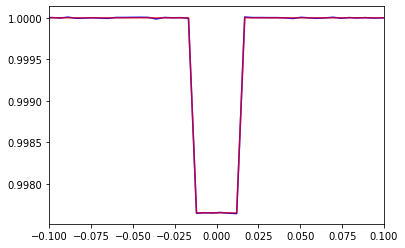

In [344]:
plt.plot(time, nflux, c='blue', alpha=1.0)
plt.plot(time, fit, c='red', alpha=0.7)
#plt.plot(time, fit2, c='green', alpha=0.7)
# plt.axvline(0.0-(T14/86400.0)/2.0, c='b', alpha=0.3)
# plt.axvline(0.0+(T14/86400.0)/2.0, c='b', alpha=0.3)
# plt.axvline(0.0-(T23/86400.0)/2.0, c='r', alpha=0.3)
# plt.axvline(0.0+(T23/86400.0)/2.0, c='r', alpha=0.3)
plt.xlim(-0.1, 0.1)

# Kepler Catalog Rhos

In [286]:
gs_t, rho_c, rho_s_cat, T14s, T23s = ph.get_g_distribution(rhos, p_f, perr_f, rprs_f, rprserr_f, T14, T14err, T23, T23err)
gs = gs_t

g_mean = np.mean(gs)
g_sigma = np.mean(np.abs(ph.get_sigmas(gs)))

100%|██████████| 1000/1000 [00:00<00:00, 84054.19it/s]


In [287]:
g_mean

1.3990082960631516

In [288]:
g_sigma

0.1856653121148113

In [289]:
np.mean(rho_s_cat)

14081.965605960539

In [290]:
np.mean(rho_c)

34985.89917844875

# Gaia Rhos

In [297]:
gs_t, rho_c, rho_s_spec, T14s, T23s = ph.get_g_distribution(rhos_gaia, p_f, perr_f, rprs_f, rprserr_f, T14, T14err, T23, T23err)
gs = gs_t

g_mean = np.mean(gs)
g_sigma = np.mean(np.abs(ph.get_sigmas(gs)))

100%|██████████| 1000/1000 [00:00<00:00, 96729.87it/s]


In [298]:
g_mean

0.9740842176154313

In [299]:
g_sigma

0.07118898716945155

# Gaia Rhos With Manual e=0 Fit

In [294]:
gs_t, rho_c, rho_s_spec, T14s, T23s = ph.get_g_distribution(rhos_gaia, p_f2, perr_f2, rprs_f2, rprserr_f2, T142, T14err2, T232, T23err2)
gs = gs_t

g_mean = np.mean(gs)
g_sigma = np.mean(np.abs(ph.get_sigmas(gs)))

100%|██████████| 1000/1000 [00:00<00:00, 98464.77it/s]


In [295]:
g_mean

0.7043115618038862

In [250]:
g_sigma

0.04979058388323471

In [251]:
np.mean(rho_s_spec)

38914.793390409744

In [127]:
np.mean(rho_c)

13240.860173251594

In [300]:
#Guesses
w_guess = 0.0
e_guess = 0.0

solnx = (w_guess, e_guess)

In [301]:
pos = solnx + 1e-4 * np.random.randn(32, 2)
nwalkers, ndim = pos.shape

In [302]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, ph.log_probability, args=(g_mean, g_sigma), threads=4)
sampler.run_mcmc(pos, 5000, progress=True);

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [00:07<00:00, 633.14it/s]


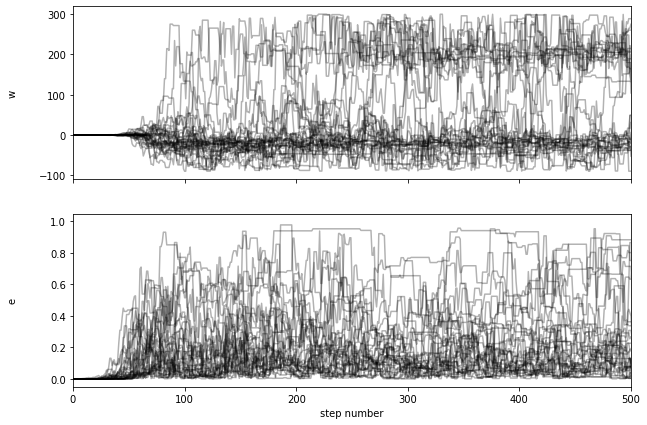

In [303]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["w", "e"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.set_xlim(0, 500)

axes[-1].set_xlabel("step number");

In [304]:
import corner

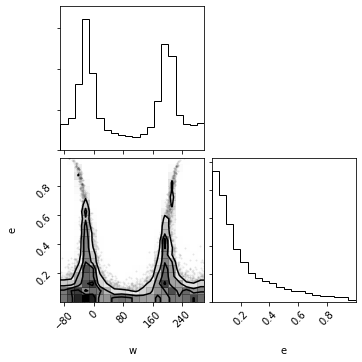

In [305]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
fig = corner.corner(flat_samples, labels=labels)